Performs the predator/prey model optimization and generates plots seen in the UQ4K paper.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

sys.path.insert(0, '../')

# uq4k modules
from uq4k.blackbox.bb_optimizer import BbOpt
from uq4k.models.loss import MeritFunc
from uq4k.plotting.pred_prey import plot_dyn_and_data
from uq4k.models.predprey_model import PredPrey

plt.style.use("seaborn-white")

# Generate Data

In [2]:
# time steps at which to evalutate the model
eval_times = np.linspace(start=0, stop=20, num=200)

# initial conditions
PREY_INIT = 30
PRED_INIT = 10

# rate of change params
ALPHA = 0.55
BETA = 0.025
DELTA = 0.02
GAMMA = 0.8

# conditions for the parameters of interest
alpha_init = 5
gamma_init = 5
alpha_bounds = (-5, 5)
gamma_bounds = (-5, 5)

# estimation noise parameter
SIGMA = 5

In [3]:
# initialize the predator/prey model
pred_prey_mod = PredPrey(
    alpha=alpha_init,
    alpha_bounds=alpha_bounds,
    gamma=gamma_init,
    gamma_bounds=gamma_bounds,
    beta=BETA,
    delta=DELTA,
    prey_init=PREY_INIT,
    pred_init=PRED_INIT,
    time_idx=eval_times,
)

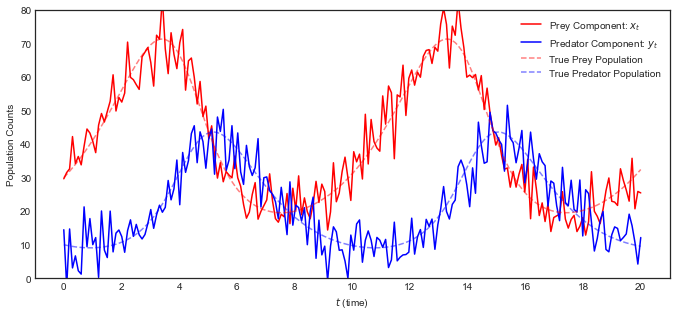

In [4]:
# generate some data
THETA_TRUE = np.array([ALPHA, GAMMA])
pop_dyn_true = pred_prey_mod(THETA_TRUE)
data = pop_dyn_true + stats.norm(loc=0, scale=SIGMA).rvs(size=(eval_times.shape[0], 2))

# plot the population dynamics
plot_dyn_and_data(evals_times=eval_times, pop_dyn=pop_dyn_true, data=data)

# Perform Optimization

In [5]:
# set optimization parameters
EPSILON = 0.0001                   # stopping criterion for odad_min_e_ball algo
CONF_LEV = 0.95                    # 1 - beta_alpha - i.e., prob not violating
THETA_INIT = np.array([0.5, 0.5])  # starting point for MLE optimization
MU = 1e13                          # strength of penalty
BOUNDS = [[-5, 5]] * 2             # variable bounds for diff evol algo
MAX_IT = 10                        # controls number of steps in ball algo

In [7]:
# create objective function and optimizer objects
objective_obj = MeritFunc(forward_model=pred_prey_mod, mu=MU, data=data)
optimizer = BbOpt(objective_obj=objective_obj)
    
# perform the optimization
mle_theta, M_alpha, S, center, radius_0 = optimizer.optimize_min_e_ball(
    sigma_2=np.square(SIGMA),
    data=data,
    theta_init=THETA_INIT,
    epsilon_0=EPSILON,
    conf_lev=CONF_LEV,
    man_delta=None,
    bounds=BOUNDS,
    max_iter=MAX_IT,
)

print("----- Center and Radius -----")
print(S)
print(center)
print(radius_0)

# perform optimization to find dirac weights
p_opt = optimizer.weight_optimization(S=S)
print("----- Dirac Weights -----")
print(p_opt)

----- Center and Radius -----
[[0.54445744 0.80432494]
 [0.54457044 0.80471865]
 [0.54473823 0.80481692]]
[0.54459783 0.80457093]
0.0002832331449790864
----- Dirac Weights -----
[0.40647365 0.23780708 0.35571928]
